In [1]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
from tf_keras import layers, utils, Model
import tensorflow as tf
plt.style.use('ggplot')


In [2]:

df = pd.read_csv('./risk_of_fire_south_america.csv')

C:\Users\brian\AppData\Local\Temp\ipykernel_26920\3031759822.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./risk_of_fire_south_america.csv')


In [3]:
df.head()

lat     lon             datetime country   state    county biome
0  -8.823 -77.944  2003-09-15 18:28:00    Peru  Ancash   Huaylas   NaN
1  -7.797 -75.313  2003-09-02 18:59:00    Peru  Loreto   Ucayali   NaN
2  -6.545 -75.197  2003-08-31 19:11:00    Peru  Loreto   Ucayali   NaN
3 -11.698 -74.377  2003-08-19 18:45:00    Peru   Junín    Satipo   NaN
4 -10.614 -75.393  2003-07-20 18:33:00    Peru   Pasco  Oxapampa   NaN

In [4]:

heatmap, xedges, yedges = np.histogram2d(df["lon"], df['lat'], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.figure().set_size_inches(30,10)
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()


<Figure size 640x480 with 0 Axes>

In [5]:
df['datetime'] = df['datetime'].astype('datetime64[ns]')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df[['year','month']] = df[['year','month']].astype('string')


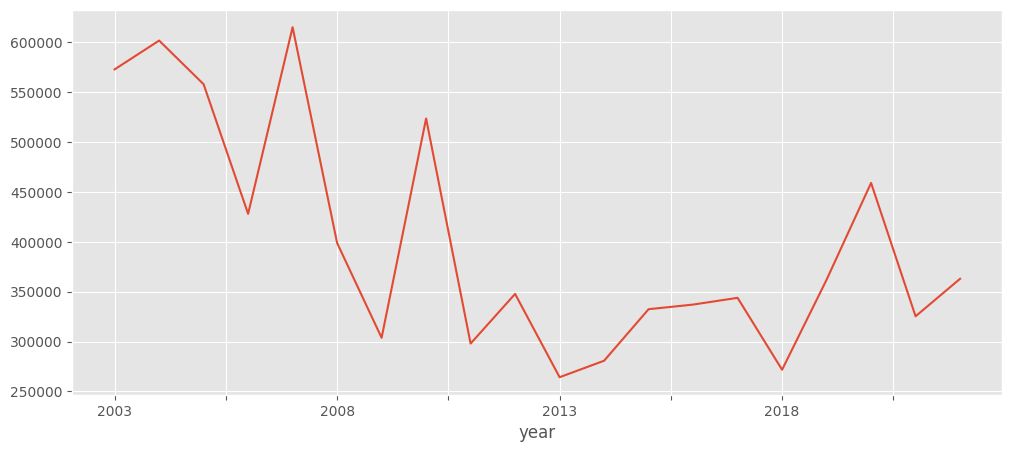

In [6]:
df['year'].value_counts().sort_index().plot(kind='line', subplots=True, figsize=(12, 5))
plt.show()


In [7]:
df_input = df.copy()
df_input.sort_values("datetime")
df_input[["year","week","day"]] = df["datetime"].dt.isocalendar()
df_input = df_input[["year","week","day","lat", "lon", "biome", "county"]]
df_input = pd.get_dummies(df_input, columns=["biome"], prefix="biome")
le = LabelEncoder()
df_input['county'] = le.fit_transform(df_input["county"])
df_input = df_input.astype(float)

In [8]:
# np_in = df_input.drop(columns=["lat", "lon"]).to_numpy()
# np_out = df_input[["lat", "lon"]]
# print(np_in.shape, np_out.shape)

series = df_input.to_numpy()
train_series = series[:-len(series)//5]
test_series = series[-len(series)//5:]
train_dataset = utils.timeseries_dataset_from_array(
  train_series, train_series, sequence_length=10
)#.batch(1000)

test_dataset = utils.timeseries_dataset_from_array(
  test_series, test_series, sequence_length=10
)#.batch(1000)

df_input.dtypes

year                     float64
week                     float64
day                      float64
lat                      float64
lon                      float64
county                   float64
biome_amazon             float64
biome_atlantic forest    float64
biome_dry woodland       float64
biome_pampas             float64
biome_savanna            float64
dtype: object

In [9]:
inputs = layers.Input(batch_size=1000, shape=(10, 11))
outputs = layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(inputs)

outputs = layers.TimeDistributed(layers.BatchNormalization())(outputs)
outputs = layers.TimeDistributed(layers.Dense(64))(outputs)
outputs = layers.TimeDistributed(layers.Dropout(0.2))(outputs)

outputs = layers.TimeDistributed(layers.BatchNormalization())(outputs)
outputs = layers.TimeDistributed(layers.Dense(32))(outputs)
outputs = layers.TimeDistributed(layers.Dropout(0.3))(outputs)

outputs = layers.TimeDistributed(layers.BatchNormalization())(outputs)
outputs = layers.TimeDistributed(layers.Dense(11))(outputs)
outputs = layers.TimeDistributed(layers.Dropout(0.5))(outputs)

outputs = layers.Flatten()(outputs)
outputs = layers.Dense(11, activation="relu")(outputs)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [10]:
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train) # Assuming a dictionary with inputs
# y_train = sc.fit_transform(y_train) # and outputs

# model.fit(x_train, y_train, batch_size=1000)
model.fit(train_dataset)



 4005/49915 [=>............................] - ETA: 13:55 - loss: 445255.5625 - accuracy: 0.8120

KeyboardInterrupt: 

In [13]:
# x_train = sc.fit_transform(x_train) # Assuming a dictionary with inputs
# y_train = sc.fit_transform(y_train) # and outputs

# model.evaluate(dataset)
predictions = model.predict(test_dataset)

12479/12479 [==============================] - 91s 7ms/step


In [18]:
predictions

array([[2434.0903,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [2246.6404,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [2318.4512,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [6176.385 ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [6176.385 ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [6176.385 ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

<Figure size 640x480 with 0 Axes>

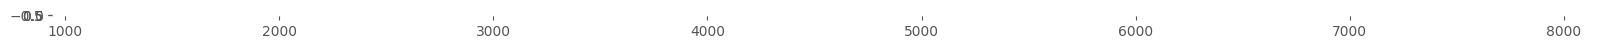

In [17]:
heatmap, xedges, yedges = np.histogram2d(predictions[:,0], predictions[:,1], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.figure().set_size_inches(30,10)
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()
